In [1]:
import pandas as pd
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
df = pd.read_pickle('ski_pickle_clean.pkl')

In [3]:
#Let's take a look
df.head()

,Core,Length,Claimed_Weight,Real_Price,Turn_Radius,Tip_Width,Width_Underfoot,Tail_Width,carbon,glass,...,wood,paulownia,balsa,aspen,maple,caruba,titanium,aluminum,bamboo,titanal
0,balsa wood,168.0,2.875,879.20,15.0,141.0,112.0,128.0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,"aspen wood, carbon fiberglass",163.0,6.750,486.46,17.0,126.0,96.0,108.0,1,1,...,1,0,0,1,0,0,0,0,0,0
2,"aspen wood, carbon fiberglass",188.0,6.750,486.46,20.0,135.0,102.0,115.0,1,1,...,1,0,0,1,0,0,0,0,0,0
8,"paulownia wood, carbon",176.0,5.750,489.96,21.0,126.0,96.0,114.0,1,0,...,1,1,0,0,0,0,0,0,0,0
9,"3D-shaped wood (poplar, paulownia), triaxial c...",175.0,6.375,561.71,16.5,130.0,101.0,118.0,1,0,...,1,1,0,0,0,0,0,1,0,1


In [4]:
#Don't want core now that we've got dummy variables
df = df.drop('Core', axis=1)

In [5]:
df.shape

(467, 24)

In [6]:
df.isnull().sum()

Length             0
Claimed_Weight     0
Real_Price         0
Turn_Radius        0
Tip_Width          0
Width_Underfoot    0
Tail_Width         0
carbon             0
glass              0
kevlar             0
flax               0
poplar             0
ash                0
beech              0
wood               0
paulownia          0
balsa              0
aspen              0
maple              0
caruba             0
titanium           0
aluminum           0
bamboo             0
titanal            0
dtype: int64

In [7]:
df.sum()

Length              81782.00000
Claimed_Weight       3268.96875
Real_Price         278519.48000
Turn_Radius          9035.00000
Tip_Width           60516.00000
Width_Underfoot     45579.00000
Tail_Width          54589.00000
carbon                191.00000
glass                 119.00000
kevlar                 13.00000
flax                   11.00000
poplar                189.00000
ash                    32.00000
beech                  57.00000
wood                  211.00000
paulownia             114.00000
balsa                  26.00000
aspen                  49.00000
maple                  26.00000
caruba                  1.00000
titanium                6.00000
aluminum               16.00000
bamboo                 37.00000
titanal                76.00000
dtype: float64

In [8]:
#Too many materials! Drop any with under 20
#Then drop a few based on correlation
#Few more based on p values from ols
df = df.drop(['caruba', 'titanium', 'flax', 'kevlar', 'paulownia', 'ash', 'carbon', 
              'glass'], axis = 1)

In [9]:
#Train/test split
X = df.drop(['Real_Price'], axis=1)
y = df['Real_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
X_train.shape

(373, 15)

In [11]:
#Scale
ssX = StandardScaler()
X_train_scalable = X_train[X_train.columns[:6]]
X_train_scaled1 = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = X_train.columns[:6])
X_train_scaled  = pd.concat([X_train_scaled1, X_train[X_train.columns[6:]].reset_index().drop('index', axis=1)], axis = 1)

X_test_scalable = X_test[X_test.columns[:6]]
X_test_scaled1 = pd.DataFrame(ssX.transform(X_test_scalable), columns = X_train.columns[:6])
X_test_scaled = pd.concat([X_test_scaled1, X_test[X_test.columns[6:]].reset_index().drop('index', axis=1)], axis = 1)

In [12]:
X_train_scaled.shape

(373, 15)

In [13]:
df_train = pd.concat([X_train_scaled, y_train.reset_index().drop('index', axis=1)], axis=1)
df_train.shape

(373, 16)

In [14]:
#Pretty bad, dropped the lowest few and then anything below .01
df_train.corr()

,Length,Claimed_Weight,Turn_Radius,Tip_Width,Width_Underfoot,Tail_Width,poplar,beech,wood,balsa,aspen,maple,aluminum,bamboo,titanal,Real_Price
Length,1.000000,0.241555,0.455958,0.484869,0.457626,0.464301,0.117886,0.033825,-0.055783,0.009639,0.092879,0.064375,0.106005,0.040901,-0.004778,0.102955
Claimed_Weight,0.241555,1.000000,0.032039,0.333174,0.204114,0.295461,0.148936,0.095274,0.007972,-0.086138,0.019136,0.040248,-0.100273,0.184438,0.110923,-0.031304
Turn_Radius,0.455958,0.032039,1.000000,0.190414,0.348985,0.205071,0.055810,0.042150,-0.196531,0.022008,0.045150,0.056009,0.033978,-0.037262,-0.068175,0.075790
Tip_Width,0.484869,0.333174,0.190414,1.000000,0.847177,0.944213,0.091977,-0.045250,0.009615,0.070068,0.213947,0.048081,0.037948,0.193284,-0.193013,0.033288
Width_Underfoot,0.457626,0.204114,0.348985,0.847177,1.000000,0.866339,0.069796,-0.070070,-0.068412,0.111414,0.210359,0.012607,0.036859,0.170696,-0.195718,0.023655
Tail_Width,0.464301,0.295461,0.205071,0.944213,0.866339,1.000000,0.085079,-0.073753,-0.031963,0.101533,0.211244,0.071868,0.031201,0.210268,-0.201562,-0.001912
poplar,0.117886,0.148936,0.055810,0.091977,0.069796,0.085079,1.000000,0.286282,-0.190667,-0.125736,-0.234022,-0.013098,0.155732,0.270002,0.098161,-0.031863
beech,0.033825,0.095274,0.042150,-0.045250,-0.070070,-0.073753,0.286282,1.000000,0.072915,0.011393,-0.111764,-0.088321,-0.066510,-0.101400,0.282424,0.195653
wood,-0.055783,0.007972,-0.196531,0.009615,-0.068412,-0.031963,-0.190667,0.072915,1.000000,0.037099,0.009628,-0.234834,0.050222,-0.210984,0.056192,-0.014228
balsa,0.009639,-0.086138,0.022008,0.070068,0.111414,0.101533,-0.125736,0.011393,0.037099,1.000000,-0.072515,-0.057305,-0.043154,-0.065791,0.077150,0.226819


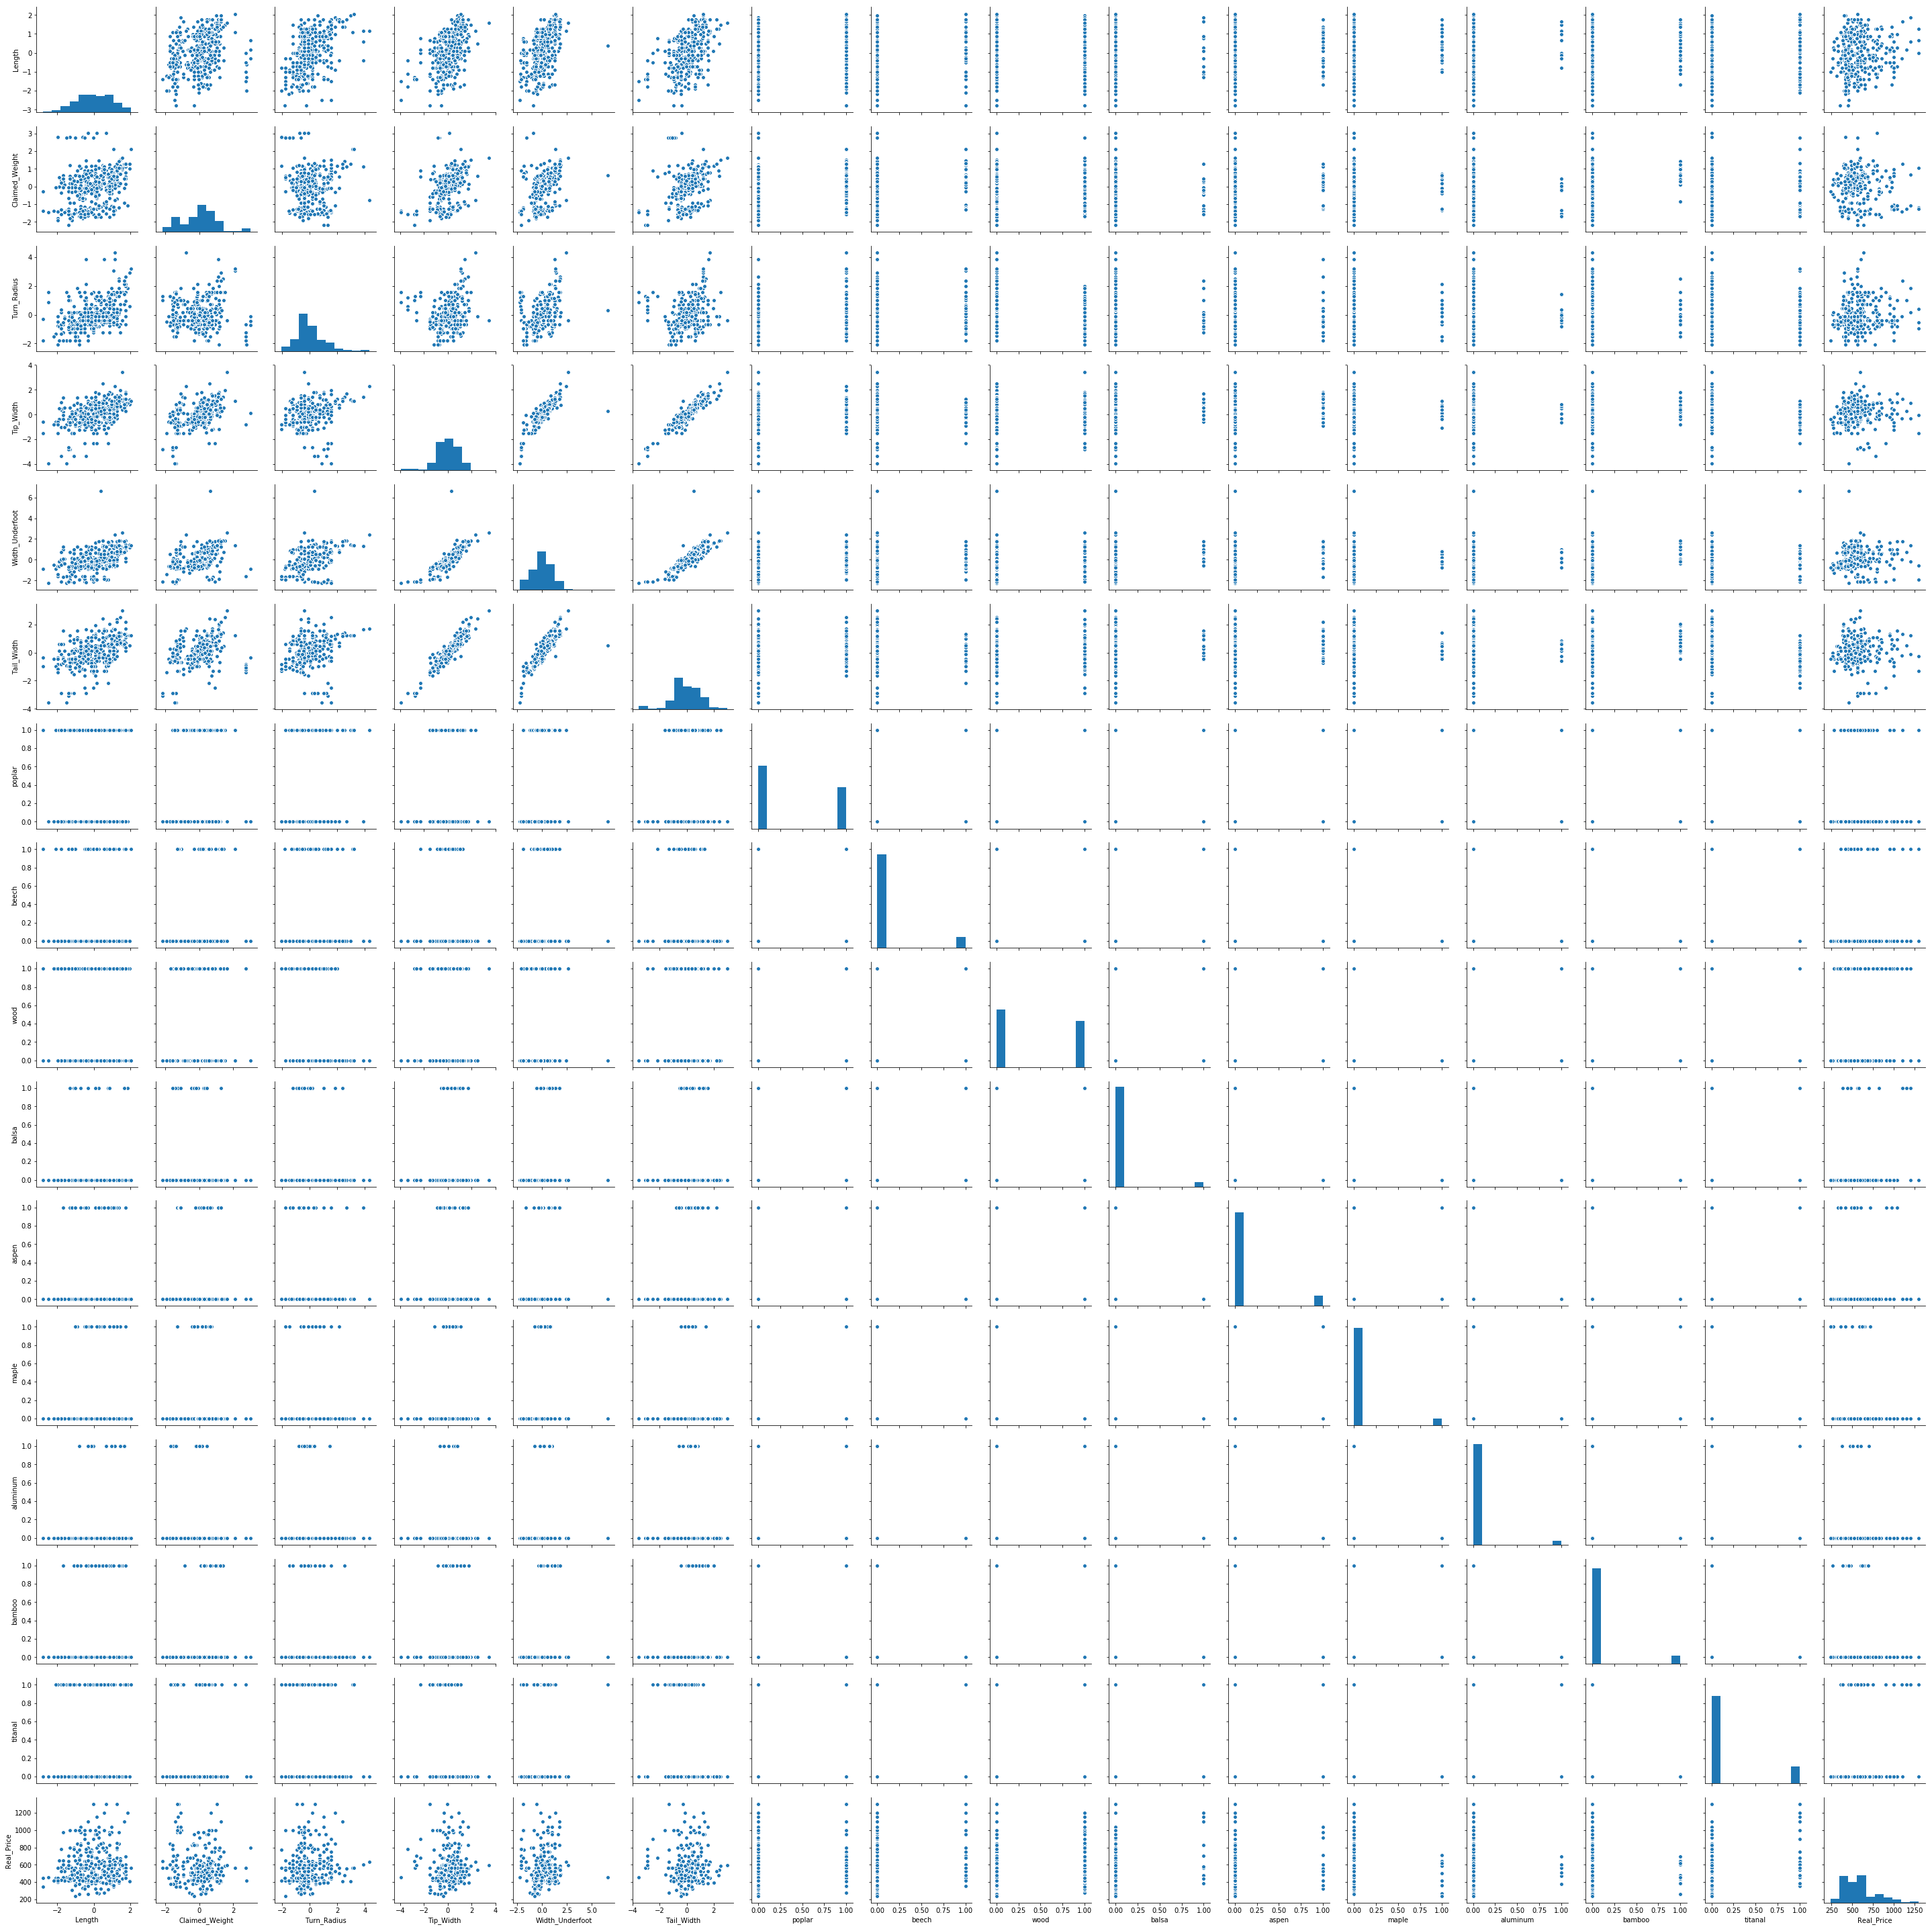

In [15]:
sns.pairplot(df_train)

In [16]:
#Create Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.score(X_train_scaled, y_train)

0.17712345597274604

In [17]:
#Cross Validation
scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=10)

print((scores).mean())

0.04667924724958773


Text(0,0.5,'Residuals')

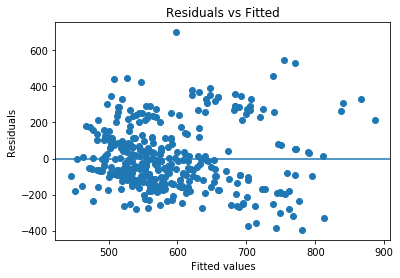

In [18]:
resid_plot = plt.figure()
y_predict = lin_reg.predict(X_train_scaled)
resid_plot = plt.scatter(y_predict, np.asarray(y_train) - y_predict)
resid_plot.axes.axhline(0)
resid_plot.axes.set_title('Residuals vs Fitted')
resid_plot.axes.set_xlabel('Fitted values')
resid_plot.axes.set_ylabel('Residuals')


In [19]:
mse = ((np.asarray(y_train) - y_predict)**2).sum()/ len(y_train)
mse

31782.618161642

In [20]:
features_only_df_train = df_train.drop('Real_Price', axis=1)

In [21]:
#This was a toy model I played around with for feature selection on p values
string_list = list(df_train.columns)
string_list.pop()
model_string = 'Real_Price ~ ' + ' + '.join(string_list)
model = smf.ols(model_string, data=df_train[df_train.index!=309])
model_fitted = model.fit()
model_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Real_Price   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     5.109
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           3.42e-09
Time:                        23:26:10   Log-Likelihood:                -2456.5
No. Observations:                 372   AIC:                             4945.
Df Residuals:                     356   BIC:                             5008.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         564.7452     18.986     29.746      0.000     527.407     602.084
Length             20.9580     12.197      1.718      0.087      -3.030      44.946
Claimed_Weight    -16.9468     10.807     -1.568      0.118     -38.201       4.308
Turn_Radius         7.4225     11.660      0.637      0.525     -15.508      30.353
Tip_Width          69.4537     30.730      2.260      0.024       9.019     129.889
Width_Underfoot   -11.1780     21.076     -0.530      0.596     -52.627      30.271
Tail_Width        -65.9373     31.586     -2.088      0.038    -128.055      -3.820
poplar            -10.6715     23.003     -0.464      0.643     -55.911      34.568
beech             107.2660     35.481      3.023      0.003      37.487     177.045
wood              -25.7035     20.975     -1.225      0.221     -66.954      15.547
balsa             212.6692     47.522      4.475      0.000     119.211     306.128
aspen             125.2997     34.189      3.665      0.000      58.062     192.537
maple             -67.9089     40.938     -1.659      0.098    -148.420      12.602
aluminum          -92.6022     54.945     -1.685      0.093    -200.661      15.456
bamboo             16.0477     38.983      0.412      0.681     -60.619      92.714
titanal            76.1208     29.652      2.567      0.011      17.805     134.437
==============================================================================
Omnibus:                       27.142   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.968
Skew:                           0.688   Prob(JB):                     1.89e-07
Kurtosis:                       3.323   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#Check Polynomial regression
def get_polynomial_regression(x_values, y_values):
    best_model = 0
    best_model_score = 0
    for degree in range(5):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(x_values, y_values)
        score = cross_val_score(lin_reg, X_train_scaled, y_train, cv=10).mean()
        print(degree)
        print(score)
        if score > best_model_score:
            best_model_score = score
            best_model = est
    print(best_model_score)
    return best_model
        
        

In [23]:
#Doesn't get better than polynomial 1
poly_model = get_polynomial_regression(X_train_scaled, y_train)

0
0.04667924724958773
1
0.04667924724958773
2
0.04667924724958773
3
0.04667924724958773
4
0.04667924724958773
0.04667924724958773


In [25]:
#Cross Validation on test set -- pretty terrible scores, not unexpected
scores = cross_val_score(lin_reg, X_test_scaled, y_test, cv=10)
y_predict = lin_reg.predict(X_test_scaled)
mse = ((np.asarray(y_test) - y_predict)**2).sum()/ len(y_train)

print((scores).mean())
print(mse)

-0.233326234630223
10227.825359977736
